<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Categorise Subreddit Posts Using Classification ML

## Background

Deafness and blindness are two separate conditions that can affect individuals of all ages and backgrounds.

Deafness, also known as hearing loss, is a condition where a person has a partial or complete inability to hear sound in one or both ears. This can be caused by a variety of factors such as genetics, exposure to loud noises, infections, trauma, or simply aging. Deafness can be categorized as conductive, sensorineural, or mixed, depending on which part of the ear is affected.

Blindness, on the other hand, is a condition where a person has little to no ability to see. This can be caused by various factors such as genetics, eye infections, injuries, or diseases such as glaucoma or macular degeneration. Blindness can be categorized as partial or complete, and can occur at any age.

Both deafness and blindness can have a significant impact on an individual's quality of life, as they can affect communication, mobility, education, and employment opportunities. However, there are many resources and technologies available to help individuals with these conditions, such as sign language interpreters, braille devices, hearing aids, and guide dogs.

## Problem Statement

I am a researcher working for a community services center that aims to provide support to people with disabilities, including those who are deaf or blind. In order to better understand the experiences and needs of these communities, I plan to classify subreddits related to deafness and blindness and evaluate the feedback and sentiment of these posts. This will help to identify common themes, concerns, and needs that are specific to these communities, which can inform the development of targeted support groups and resources.

Using machine learning algorithms, I will classify subreddits related to deafness and blindness into separate categories, and then evaluate the sentiment of the posts in each category using natural language processing techniques. For the classification models, I will priotise generalization error between training and testing data. It is also essential to consider sensitivity and specificity in additional to the overall accuracy.

## Libraries

In [1]:
import requests
import random
import time
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from nltk.sentiment import SentimentIntensityAnalyzer

## Data Collection

In [2]:
# #function to scrap reddit post
# def get_reddit_post(subreddit, n):
    
#     #url and criteria to scrap posts
#     url = "https://api.pushshift.io/reddit/search/submission"
#     params = {"subreddit": subreddit, "size": 1000}
    
#     #list to store scraped data
#     raw_data_list = []
    
#     #loops to get 1000 posts once until it meets the number requirement (n)
#     while len(raw_data_list) < n:
#         request = requests.get(url, params=params)
        
#         #if server has successfully processed the request
#         if request.status_code == 200:
#             raw_data = request.json()["data"]
#             raw_data_list.extend(raw_data)
#             print(f"Imported {len(raw_data_list)} posts related to {subreddit}...")

#             #new criteria (older date) to pass in next round of retrieval
#             date_cutoff = raw_data[-1]["created_utc"]
#             params = {"subreddit": subreddit, "size": 1000, "before": date_cutoff}
                
#         #if not, break the loop
#         else:
#             print("Status code: ", request.status_code)
#             print("Failed to retrieved data.")
#             continue
            
#         #generate random sleep duration to simulate human user behavior
#         sleep_duration = random.randint(5,15)
#         time.sleep(sleep_duration)
    
#     return raw_data_list

In [3]:
# %%time
# #scrap 'blind' related post
# #n=2500 because this subreddit contains more rows that are less informative
# blind = get_reddit_post("Blind", 2500)

In [4]:
# %%time
# #scrap 'deaf' related post
# deaf = get_reddit_post("deaf", 2000)

In [5]:
# #create a list to include interested features
# features = ['subreddit', 'title', 'selftext']

# #create dataframe for each subreddits
# df_blind = pd.DataFrame(blind)[features]
# df_deaf = pd.DataFrame(deaf)[features]

# #combine both dataframes
# df = pd.concat([df_blind, df_deaf], axis=0)

# #save as csv
# df.to_csv("blind_and_deaf.csv", index=False)

In [6]:
#pls ignore this
# content_type = request.headers.get("content-type")

## Data Loading

In [7]:
df = pd.read_csv("blind_and_deaf.csv")

## Data Cleaning: Initial Check

In [8]:
df.head()

,subreddit,title,selftext
0,Blind,Idea for a pokemon rom hack for blind people,I myself am not blind but I wanted to share th...
1,Blind,Light for stove,I'm looking for ideas for more light on my sto...
2,Blind,Does anyone use a Mail reading service?,I imagine this exists but I don't know where t...
3,Blind,Vision buddy,[removed]
4,Blind,What would you say are some must have resource...,NaN


## Data Cleaning: Null Value

In [9]:
#check for number of null value
df.isnull().sum()

subreddit       0
title           0
selftext     1855
dtype: int64

In [10]:
#drop null value that appears only in selftext
#selftext is generally more informative
df = df.dropna(axis=0)

## Data Cleaning: Content

In [11]:
# check for content "[removed]" and "[deleted]"
row_removed_deleted = df[(df["title"] == "[removed]") | (df["selftext"] == "[removed]") |
                         (df["title"] == "[deleted]") | (df["selftext"] == "[deleted]")]
row_removed_deleted.shape

(522, 3)

In [12]:
# drop those row that have content being removed because it is not informative
df = df.drop(row_removed_deleted.index, axis=0).reset_index(drop=True)

## Data Cleaning: Duplication

In [13]:
#check for duplicated row
row_duplicated = df[df.duplicated()]
row_duplicated.shape

(10, 3)

In [14]:
#drop duplicated row
df = df.drop(row_duplicated.index, axis=0).reset_index(drop=True)

## Data Cleaning: Data Type

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3243 entries, 0 to 3242
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  3243 non-null   object
 1   title      3243 non-null   object
 2   selftext   3243 non-null   object
dtypes: object(3)
memory usage: 76.1+ KB


## Data Cleaning: Final Data Set

In [16]:
# create a column to combine both column "title" and "selftext"
df["title_selftext"] = df["title"] + " " + df["selftext"]

# masking to extract only interested column
df = df[["subreddit", "title_selftext"]]

## Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**subreddit**|*object*|blind, deaf|0 represent blind, 1 represent deaf.|
|**title_selftext**|*object*|title, selftext| Combination of words in title and selftext.|\

## Data Preprocessing: Binarize Target Variable

In [17]:
#convert subreddit into binary group
#0 represent blind
#1 represent deaf
df["subreddit"] = df["subreddit"].map({"Blind":0, "deaf": 1})

## Data Preprocessing: HTML Tags and URL Links

In [18]:
def remove_html(content):
    soup = BeautifulSoup(content, "html.parser")
    text = soup.get_text()
    # remove all newline, tab, and carriage return characters
    text = text.replace('\n', '').replace('\t', '').replace('\r', '')
    return text
    
df["title_selftext"] = df["title_selftext"].apply(remove_html)

C:\Users\szehu\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [19]:
def remove_urls(text):
    # Define the regular expression pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Replace all matched URLs with an empty string
    cleaned_text = url_pattern.sub('', text)
    
    return cleaned_text

df["title_selftext"] = df["title_selftext"].apply(remove_urls)

## Data Preprocessing: Train and Split

In [20]:
#check for value count to make sure groups are balanced
df["subreddit"].value_counts(normalize=True)

1    0.539315
0    0.460685
Name: subreddit, dtype: float64

In [21]:
#define X and y
X = df["title_selftext"]
y = df["subreddit"]

#split 0.75 to train and 0.25 to test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state= 33)

## NLP Setting

Stopwords: 
Two lists of stop words will be tested in gridsearchcv to find out the best performance parameter.
1. "english" in count vectorizer + keywords: "blind" and "deaf".
2. Only keywords: "blind" and "deaf".

In [22]:
#list of stop words from "english" in CountVectorizer
stop_words = list(CountVectorizer(stop_words="english").get_stop_words())

#include the keywords in list of stop words
keywords = ["deaf", "blind"]
stop_words += keywords

Tokenizer: A function is created using TreebankWordTokenizer(). It split text into words and punctuation marks, and is designed to handle common text formatting conventions like hyphenated words and contractions. It the removes non letter words, and eliminate token that has only 1 letter (less informative).

In [23]:
# tokenizer function
def tokenizer(content):
    
    #initiate tokenizer
    tokenizer = TreebankWordTokenizer()
    tokens = tokenizer.tokenize(content)
    
    # Remove special characters and token that has only one letter using regex
    non_empty_token = []             
    for token in tokens:
        cleaned_token = re.sub(r'[^\w]+','',token)    #substitute non letter word to empty string
        if cleaned_token and len(cleaned_token)>1:    #token that has one letter is not informative
            non_empty_token.append(cleaned_token)     #append to list to remove empty string         
        pass
    return non_empty_token

In [24]:
# #gave up using sent and word tokenizer from nltk.
#Scores are almost same, but taking double time.

# import nltk
# from nltk.tokenize import sent_tokenize, word_tokenize

# def tokenizer(content):
#     # Tokenize into sentences
#     sentences = sent_tokenize(content)

#     # Tokenize each sentence into words
#     tokens = []
#     for sentence in sentences:
#         words = word_tokenize(sentence)
#         tokens.extend(words)

#     # Remove special characters and tokens with only one letter
#     non_empty_tokens = []
#     for token in tokens:
#         cleaned_token = re.sub(r'[^\w]+', '', token)
#         if cleaned_token and len(cleaned_token) > 1:
#             non_empty_tokens.append(cleaned_token)

#     return non_empty_tokens


Stemmer: Porter Stemmer is used in this project, rather than WordNet Lemmatizer because lemmatizer is slower. Also, stemming tends to be cruder than using lemmatization which by default only works on nouns and handling grammar issue. Porter stemmer reduces a word to its root or base form, with the goal of grouping together all the different inflected forms of a word so they can be treated as a single item. 

In [25]:
def porterstemmer(content):
    stemmer = PorterStemmer()
    tokens = word_tokenize(content.lower())
    
    stemmed_token_list = []
    for token in tokens:
        stemmed_token = stemmer.stem(token)
        if stemmed_token:
            stemmed_token_list.append(stemmed_token)    #append to list to remove empty string and avoid TypeError
        pass
    
    return stemmed_token

## Data Preprocessing: EDA

##### 20 most important words

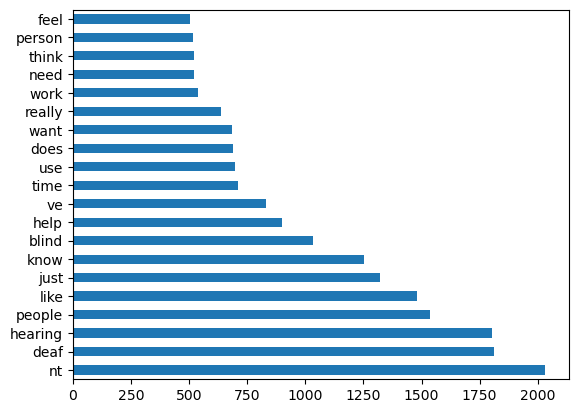

In [59]:
cv = CountVectorizer(tokenizer=tokenizer,
                    stop_words="english")   #w/o removing keywords to compare the frequency

X_df = cv.fit_transform(X_train)
X_plot = pd.DataFrame(X_df.todense(), columns=cv.get_feature_names_out())

X_plot.sum().sort_values(ascending=False).head(20).plot(kind="barh");

The most important words appeared to include 'deaf' and 'blind'. That is the reason they are excluded in tokenization because it will be meaningless for classification if the keywords are included.

##### Investigation of most important word 'nt'

In [27]:
# find word of 'nt' to see if this word has a special meaning or come our from contraction like isn't, hasn't, don't
# check count of list to match with the frequency of word in plot
count = 0
for row in df["title_selftext"]:
    output = re.findall(r"\bnt\b", row)
    if len(output) >=1:
        print(output, "\n", row, "\n")
        count += len(output)
count

0

In [28]:
# find word that end with 'nt' to confirm most of them are contraction
# uncomment to see the output
count = 0
for row in df["title_selftext"]:
    output = re.findall(r"\b\w*n't\b", row)
    if len(output) >=1:
#         print(output, "\n", row, "\n")
        count += len(output)
count

2731

It is cleared that 'nt' has no special meaning, they are just contraction like can't, don't, hasn't, haven't...They are separated by tokenization. 

It is also important to highlight that most of the tokens appeared to be a common word in communication/ opinion expression. For example, 'just', 'know', 'does', 'want'. This could contribute to model overfitting. Hence, other than count vectorizer, tf-idf vectorizer will be utilized to take into consideration the weightage of each token. tf-idf vectorizer weights more heavily for words that occur often in one document but don't occur in many documents.

In [29]:
# find word of 'deaf' to have a view of the community in reddit
# uncomment to see the output
count = 0
for row in df["title_selftext"]:
    output = re.findall(r"\bdeaf\b", row)
    if len(output) >=1:
#         print(output, "\n", row, "\n")
        count += len(output)
count

1796

In [30]:
# find word of 'blind' to have a view of the community in reddit
# uncomment to see the output
count = 0
for row in df["title_selftext"]:
    output = re.findall(r"\bblind\b", row)
    if len(output) >=1:
#         print(output, "\n", row, "\n")
        count += len(output)
count

1333

## Modeling

Modeling Function: A function is created to automate gridsearchcv. The following are included:
1. training score
2. testing score
3. mean cross-validated score of the best_estimator (best score)
4. confusion matrix
5. accuracy score
6. precision score
7. sensitivity (recall/ true positive rate)
8. specificity (true negative rate)
9. best estimator

Accuracy measures the number of correct predictions made by a model in relation to the total number of predictions made.

Precision measures the proportion of positively predicted labels that are actually correct. This has lesser interest in this project as compared to accuracy.

However, because accuracy could be affected by imbalance class in the subreddit posts, sensitivity/true positive and specificity/true negative rates are also considered.

In [31]:
def modeling(pipe, transformer, estimator=None):
    
    #diff param for diff type of transformer (count vec, tfidf vec)
    if transformer == "cv":
        params = {'cv__analyzer': ['word'],
          'cv__tokenizer': [tokenizer],
          'cv__preprocessor': [None, porterstemmer],
          'cv__stop_words': [keywords, stop_words],
          'cv__max_features': [2000, 3000, 4000, 5000],
          'cv__ngram_range': [(1, 1), (1,2), (1,3)],
          'cv__min_df': [2, 3],
          'cv__max_df': [.9, .95],
          'cv__strip_accents': ["unicode", "ascii"]}
        
    elif transformer == "tfidf":
        params = {'tfidf__analyzer': ['word'],
          'tfidf__tokenizer': [tokenizer],
          'tfidf__preprocessor': [None, porterstemmer],
          'tfidf__stop_words': [keywords, stop_words],
          'tfidf__max_features': [2000, 3000, 4000, 5000],
          'tfidf__ngram_range': [(1, 1), (1,2), (1,3)],
          'tfidf__min_df': [2, 3],
          'tfidf__max_df': [.9, .95],
          'tfidf__strip_accents': ["unicode", "ascii"]}
     
    #additional param for diff type of estimator
    if estimator == 'log_reg':
        params['log_reg__C'] = [0.1, 1, 10]
        params['log_reg__penalty'] = ['l1', 'l2']
        params['log_reg__solver'] = ['liblinear']
        params['log_reg__max_iter'] = [100, 200, 500]
        
    elif estimator == 'knn':
        params['knn__n_neighbors'] = [3, 5, 7, 9]
        params['knn__weights'] = ['uniform', 'distance']
        params['knn__p'] = [1,2]                                  # 1 is manhattan_distance, 2 is euclidean_distance 
    
    # initiate grid search cv
    gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, verbose=1)
    # fit the gridsearch on the training data
    gs.fit(X_train, y_train)
    # make predictions on new data
    y_pred = gs.predict(X_test)

    #score for training set
    train_score = gs.score(X_train, y_train)
    print(f"Training score: {round(train_score,4)}")
    
    #score for testing set
    test_score = gs.score(X_test, y_test)
    print(f"Testing score: {round(test_score,4)}")
    
    #mean cross-validated score of the best_estimator
    if gs.best_score_ is not None:
        best_score = gs.best_score_
        print(f"Best score: {round(best_score,4)}")
    else:
        best_score = gs.best_estimator_.score(X_train, y_train)
        print("No cross-validation score was better than default parameters.")
        print(f"Best score: {round(best_score,4)}")    
        
    #confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm_multinb = confusion_matrix(y_test, y_pred)
    display_multinb = ConfusionMatrixDisplay(cm_multinb)
    display_multinb.plot();
          
    #accuracy (same as test score)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {round(accuracy, 4)}")
    
    #precision
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {round(precision, 4)}")
                  
    #recall/ sensitivity
    sensitivity = recall_score(y_test, y_pred)  
    print(f"Sensitivity: {round(sensitivity, 4)}")
    
    #specificity
    specificity = tn/(tn+fn)
    print(f"Specificity: {round(specificity, 4)}")

    # best param
    best_params = gs.best_params_
    return(f"Params: {best_params}")

#### 1. Baseline Accuracy

In [32]:
y_train.value_counts(normalize=True)

1    0.539474
0    0.460526
Name: subreddit, dtype: float64

This is a simple baseline model that simply predict the accuracy rate for positive (deaf) and negative (blind). For the majority class (positive), it achieved an accuracy rate of 54% if all are predicted to be positive. Hence, if the predictive models are performing worse than the baseline model, it is considered to be performing poorly and required further tuning/feature engineering. The best model should have higher accuracy than baseline model, and have the optimal tradeoff between variance and sensitivity and specificity.

<a id="log_reg"></a>[2. Logistic Regression Model](#conclusion)

In [33]:
# %%time

# #count vectorizer
# pipe = Pipeline([
#         ('cv', CountVectorizer()),
#         ('log_reg', LogisticRegression())])

# modeling(pipe=pipe, transformer="cv", estimator="log_reg")

# #running time 5h 52m
# #best params: max_df=0.9, max_features=5000, min_df=2, ngram_range=(1, 3), stop_words=stop_words,
# #strip_accents=unicode, log_reg__C=0.1, log_reg__max_iter: 100, log_reg__penalty: l2, cv__preprocessor: None

# #refer screenshot for the performance/score

In [34]:
# %%time

# #tfidf vectorizer
# pipe = Pipeline([
#         ('tfidf', TfidfVectorizer()),
#         ('log_reg', LogisticRegression())])

# modeling(pipe=pipe, transformer="tfidf", estimator="log_reg")

# #running time 7h 10m
# #best params: max_df=0.9, max_features=4000, min_df=3, ngram_range=(1, 3), stop_words=stop_words,
# #strip_accents=unicode, log_reg__C=1, log_reg__max_iter: 100, log_reg__penalty: l2, tfidf__preprocessor: None

# #refer screenshot for the performance/score

Logistics regression models the relationship between input features and output labels using a logistic function, which maps input features to a predicted probability value between 0 and 1. The algorithm iteratively adjusts the parameters of the logistic function to minimize the difference between the predicted probabilities and the actual labels in the training data. It can be used to make predictions on new data by computing the predicted probability using the trained model.

Logistics reg assumes linear relationship. Also, in NLP that involves large vocabularies, it is vulnerable to overfitting as the models is too complex. These could be the reasons this model results in 6-8% of generalizaton error. Overfitting occurs in both cases using different transformers,and apparently count vectorizer has higher variance comparing to tfidf vectorizer. Although the scores achieve more than 90%, this is not considered an optimal model given the large variance.

<a id="nb"></a>[3. Naive Baiyes Model](#conclusion)

In [35]:
# %%time

# #count vectorizer
# pipe = Pipeline([
#         ('cv', CountVectorizer()),
#         ('multi_nb', MultinomialNB())])

# modeling(pipe=pipe, transformer="cv")

# #running time 28m
# #best params: max_df=0.9, max_features=3000, min_df=2, ngram_range=(1, 3), stop_words=stop_words,
# #strip_accents=unicode, preprocessor: None

In [36]:
# %%time

# #tfidf vectorizer
# pipe = Pipeline([
#         ('tfidf', TfidfVectorizer()),
#         ('multi_nb', MultinomialNB())])

# modeling(pipe=pipe, transformer="tfidf")

# #running time 28m
# #best params: max_df=0.9, max_features=2000, min_df=3, ngram_range=(1, 3), stop_words=stop_words,
# #strip_accents=unicode, preprocessor: None

Naive Bayes estimates the probability of each feature given each class using Bayes' theorem. Then, when given a new input, it calculates the probability of each class given the input features using Bayes' theorem. The class with the highest probability is then chosen as the output. 

The "naive" part of Naive Bayes comes from the assumption that the input features are conditionally independent given the class label. This assumption allows the algorithm to be computationally efficient and well-suited for high-dimensional feature space. Therefore, it has lower generalization error of 3-4%, much lower as compared to logistic regression.

The performance is better in terms of lower variance and higher accuracy of above 87% by using count vector as compared to tfidf vector, although both models have overfitting issue. The slightly higher score in sensitivity and specificity of the model using tf-idf vector is traded off for lower variance.

Overall, Naive Bayes is considered an optimal model in this project as it provides much lower variance to give much steady prediction.

<a id="knn"></a>[4. KNN Model](#conclusion)

In [37]:
# %%time

# #count vectorizer
# pipe = Pipeline([
#         ('cv', CountVectorizer()),
#         ('knn', KNeighborsClassifier())])

# modeling(pipe=pipe, transformer="cv", estimator="knn")

# #running time 6h 35m
# #best params: max_df=0.9, max_features=2000, min_df=3, ngram_range=(1, 2), stop_words=stop_words,
# #strip_accents=unicode, n_neighbors=9, knn__p: 2 (euclidean_distance), knn__weights:uniform

# #refer screenshot for the performance/score

In [38]:
# %%time

# #tfidf vectorizer
# pipe = Pipeline([
#         ('tfidf', TfidfVectorizer()),
#         ('knn', KNeighborsClassifier())])

# modeling(pipe=pipe, transformer="tfidf", estimator="knn")

# #running time 5h 24m
# #best params: max_df=0.9, max_features=5000, min_df=3, ngram_range=(1, 2), stop_words=stop_words,
# #strip_accents=unicode, n_neighbors=9, knn__p: 2 (euclidean_distance), knn__weights:uniform

# #refer screenshot for the performance/score

k-Nearest Neighbors (k-NN) is a distance-based algorithm that uses the similarities between data points to make predictions. The input data is represented as a set of feature vectors, such as word frequencies or tf-idf values. When given a new input, the algorithm identifies the k nearest neighbors to that input in the feature space. The class of the new input is then assigned based on the majority class among the k nearest neighbors.

Hence, KNN is more effective in NLP tasks that involve finding similar documents or identifying patterns in the data, such as document clustering or recommendation systems. It can be computationally expensive and may not scale well to large datasets or high-dimensional feature spaces. As the number of dimensions or features increases, the distance between any two points becomes less meaningful and the points become more uniformly distributed. This can make it difficult to find meaningful nearest neighbors and can reduce the accuracy of the k-NN algorithm.

KNN using TF-IDF vector has lower variance than using count vector because it can effectively capture the underlying structure of the data and better handle the high-dimensional, sparse nature of the feature space, while count vector introduces bias and noise into the data because it included common words that has higher frequency in the documents. This is proved by the variance output, in which count vector gives 14.52% generalization error while tfidf vector gives 4.48% variance only. 

Although the scores in KNN is above 86%, given the lower error and higher accuracy in Naive Bayes, KNN is not an optimal model in this project.

## Changes in Modeling Function

It is computationally expensive to run the model with first function. Hence, some parameter is removed, which are different options for stopwords, strip accent, preprocessor. The selected option has best performance in all previous models.

In [39]:
def modeling_2(pipe, transformer, estimator=None):
    
    #diff param for diff type of transformer (count vec, tfidf vec)
    if transformer == "cv":
        params = {'cv__analyzer': ['word'],
          'cv__tokenizer': [tokenizer],
          'cv__preprocessor': [None],
          'cv__stop_words': [stop_words],
          'cv__max_features': [2000, 3000, 4000, 5000],
          'cv__ngram_range': [(1, 1), (1,2), (1,3)],
          'cv__min_df': [2, 3],
          'cv__max_df': [.9, .95],
          'cv__strip_accents': ["unicode"]}
        
    elif transformer == "tfidf":
        params = {'tfidf__analyzer': ['word'],
          'tfidf__tokenizer': [tokenizer],
          'tfidf__preprocessor': [None],
          'tfidf__stop_words': [stop_words],
          'tfidf__max_features': [2000, 3000, 4000, 5000],
          'tfidf__ngram_range': [(1, 1), (1,2), (1,3)],
          'tfidf__min_df': [2, 3],
          'tfidf__max_df': [.9, .95],
          'tfidf__strip_accents': ["unicode"]}
     
    #additional param for diff type of estimator   
    if estimator == 'dt':
        params['dt__max_depth'] = [5,8,10]
        params['dt__min_samples_split'] = [5,10,15]
        params['dt__min_samples_leaf'] = [5,10,15]
        params['dt__ccp_alpha'] = [0, 1, 10]
        params['dt__splitter'] = ['best', 'random']
        params['dt__random_state'] = [33]
        
    elif estimator == 'bagging':                 #additional random state
        params['bagging__base_estimator__random_state'] = [33]
        params['bagging__base_estimator__max_depth'] = [5,10]
        params['bagging__base_estimator__min_samples_split'] = [5,10]
        params['bagging__base_estimator__min_samples_leaf'] = [5,10]                        
        params['bagging__base_estimator__splitter'] = ['best', 'random']
        params['bagging__base_estimator__ccp_alpha'] = [0, 1, 10]
    
        
    elif estimator == 'r_forest':                #everything same as 'dt', but without splitter because of the diff natures
        params['r_forest__max_depth'] = [5,8,10]
        params['r_forest__random_state'] = [33]
        params['r_forest__min_samples_split'] = [5,10,15]
        params['r_forest__min_samples_leaf'] = [5,10,15]
        params['r_forest__ccp_alpha'] = [0, 1, 10]
        
    elif estimator == 'extra_tree':                #everything same as 'r_forest', except the default bootstrap=False
        params['extra_tree__max_depth'] = [5,8,10]   #and multiple thresholds for each features is randomly selected
        params['extra_tree__random_state'] = [33]    #while in 'r_forest' only a single best threshold is selected
        params['extra_tree__min_samples_split'] = [5,10,15]
        params['extra_tree__min_samples_leaf'] = [5,10,15]
        params['extra_tree__ccp_alpha'] = [0, 1, 10]
    
    elif estimator == 'ada_b':                      #no bootstrap involve, not including base estimator para
        params['ada_b__learning_rate'] = [0.1, 0.3, 0.5, 0.8, 1.0]  #because by its nature i should keep as stumps
        params['ada_b__random_state'] = [33]
        params['ada_b__n_estimators'] = [30, 50, 80, 100]    
        
    # initiate grid search cv
    gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, verbose=1)
    # fit the gridsearch on the training data
    gs.fit(X_train, y_train)
    # make predictions on new data
    y_pred = gs.predict(X_test)

    #score for training set
    train_score = gs.score(X_train, y_train)
    print(f"Training score: {round(train_score,4)}")
    
    #score for testing set
    test_score = gs.score(X_test, y_test)
    print(f"Testing score: {round(test_score,4)}")
    
    #mean cross-validated score of the best_estimator
    if gs.best_score_ is not None:
        best_score = gs.best_score_
        print(f"Best score: {round(best_score,4)}")
    else:
        best_score = gs.best_estimator_.score(X_train, y_train)
        print("No cross-validation score was better than default parameters.")
        print(f"Best score: {round(best_score,4)}")    
        
    #confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm_multinb = confusion_matrix(y_test, y_pred)
    display_multinb = ConfusionMatrixDisplay(cm_multinb)
    display_multinb.plot();
          
    #accuracy (same as test score)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {round(accuracy, 4)}")
    
    #precision
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {round(precision, 4)}")
                  
    #recall/ sensitivity
    sensitivity = recall_score(y_test, y_pred)  
    print(f"Sensitivity: {round(sensitivity, 4)}")
    
    #specificity
    specificity = tn/(tn+fn)
    print(f"Specificity: {round(specificity, 4)}")

    # best param
    best_params = gs.best_params_
    return(f"Params: {best_params}")

<a id="dt"></a> [5. Decision Tree Model](#conclusion)

In [40]:
# %%time

# #count vectorizer
# pipe = Pipeline([
#         ('cv', CountVectorizer()),
#         ('dt', DecisionTreeClassifier())])

# modeling_2(pipe=pipe, transformer="cv", estimator="dt")

# #running time 2h 53m
# #best param: cv__max_df: 0.9, cv__max_features: 2000, cv__min_df: 2, cv__ngram_range: (1, 1),
# #dt__ccp_alpha: 0, dt__max_depth: 10, dt__min_samples_leaf: 10, dt__min_samples_split: 5, dt__splitter: best

# #refer screenshot for the performance/score

In [41]:
# %%time

# #tfidf vectorizer
# pipe = Pipeline([
#         ('tfidf', TfidfVectorizer()),
#         ('dt', DecisionTreeClassifier())])

# modeling_2(pipe=pipe, transformer="tfidf", estimator="dt")

# #running time 3h 5m
# #best params: 'dt__ccp_alpha': 0, 'dt__max_depth': 10, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 5,
# #'dt__splitter': 'best',  'tfidf__max_df': 0.9, 'tfidf__max_features': 3000, 'tfidf__min_df': 3,
# #'tfidf__ngram_range': (1, 3)

# #refer screenshot for the performance/score

In a decision tree, the input data is represented as a set of features, such as word frequencies or presence of certain keywords. The algorithm recursively splits the data into subsets based on the values of the input features, with the goal of maximizing the separation between the classes of interest. The splitting criterion is based on Gini impurity. Once the tree is constructed, new inputs are classified by traversing the tree based on their feature values until a leaf node is reached, which corresponds to a class label.

The reason decision tree has very low generalization error, but lower accuracy is likely because the depth is not deep enough to capture all the relevant features and their interactions. The gridsearch value to depth is given up to 10, and both vectors has best param at 10. Also, zero alpha in both cases supported the reason. In order to have higher accuracy, the value should be adjusted higher to capture more relationships between the input features and the class labels. Otherwise, random forest might address this depth issue and perform better.

The reason count vector gives lower error than tf-idf vector in this model could be because of the smaller selected max feature of 2k, compared to tf-idf which selected 3k features, which captures more noise.

Due to the very low sensitivity and specificity of around 77%-79%, Decision Tree is not considered optimal in this project unless the parameter is adjusted for further tuning.

<a id="bagging"></a>[6. Bagging Classifier](#conclusion)

In [42]:
# #count vectorizer
# pipe = Pipeline([
#         ('cv', CountVectorizer()),
#         ('bagging', BaggingClassifier(base_estimator=DecisionTreeClassifier()))])

# modeling_2(pipe=pipe, transformer="cv", estimator="bagging")

# #best params: 'bagging__base_estimator__ccp_alpha': 0, 'bagging__base_estimator__max_depth': 10,
# #'bagging__base_estimator__min_samples_leaf': 10, 'bagging__base_estimator__min_samples_split': 5,
# #'bagging__base_estimator__splitter': 'random', 'cv__max_df': 0.9, 'cv__max_features': 2000,
# #'cv__min_df': 2, 'cv__ngram_range': (1, 1)

# #refer screenshot for the performance/score

In [43]:
# #tfidf vectorizer
# pipe = Pipeline([
#         ('tfidf', TfidfVectorizer()),
#         ('bagging', BaggingClassifier(base_estimator=DecisionTreeClassifier()))])

# modeling_2(pipe=pipe, transformer="tfidf", estimator="bagging")

# #best params: bagging__base_estimator__ccp_alpha': 0, 'bagging__base_estimator__max_depth': 10,
# #'bagging__base_estimator__min_samples_leaf': 5, 'bagging__base_estimator__min_samples_split': 10,
# #bagging__base_estimator__splitter': 'best', tfidf__max_df': 0.95, 'tfidf__max_features': 3000, 
# #'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)

# #refer screenshot for the performance/score

Bagging Classifier is a type of ensemble model that uses 'bootstrap aggregating' to improve the accuracy of a classification task. It trains multiple classifiers on different subsets of the training data, and then combining their predictions to make a final prediction for each instance.

By training multiple classifiers on different subsets of the data, it learns to generalize better to new instances and reduce the impact of any noise or outliers in the data. That could be the reason this model gives the lowest generalization. Similar to Decision Tree, it has  lower error but also lower scores in sensitivity and specificity. Since the estimator of Bagging Classifier is Decision Tree, and the parameter for depth is set at maximum 10, this model might have better result if the depth is adjusted higher, and zero alpha is selected could explain this phenomena with lower error but lower accuracy.

Classifier using tf-idf vector underperforms count could be because of selection of 3k max feature and 0.95% max df in tfidf that takes in too many noise, causes it to have higher variance than count vector that selected 2k max features and 0.9% max df.

Therefore, Bagging Classifier does not qualified as optimal model in this project without fine tuning.

<a id="r_forest"></a>[7. Random Forest](#conclusion)

In [44]:
# %%time
# #count vectorizer
# pipe = Pipeline([
#         ('cv', CountVectorizer()),
#         ('r_forest', RandomForestClassifier())])

# modeling_2(pipe=pipe, transformer="cv", estimator="r_forest")

# #running time 1h 30m
# #best params: 'cv__max_df': 0.9, 'cv__max_features': 4000, 'cv__min_df': 2, 'cv__ngram_range': (1, 3)
# #r_forest__ccp_alpha': 0, 'r_forest__max_depth': 10, 'r_forest__min_samples_leaf': 5, 'r_forest__min_samples_split': 5

# #refer screenshot for the performance/score

In [45]:
# #tfidf vectorizer
# pipe = Pipeline([
#         ('tfidf', TfidfVectorizer()),
#         ('r_forest', RandomForestClassifier())])

# modeling_2(pipe=pipe, transformer="tfidf", estimator="r_forest")

# #best params: 'r_forest__ccp_alpha': 0, 'r_forest__max_depth': 10, 'r_forest__min_samples_leaf': 10,
# #'r_forest__min_samples_split': 5, 'tfidf__max_df': 0.9, 'tfidf__max_features': 4000,
# #'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)

# #refer screenshot for the performance/score

A Random Forest model involves training a large number of decision trees on random subsets of the training data and (additional layer of randomness on Bagging Classifier) a random subset of the features. Each decision tree votes on the output for each input instance, and the final prediction is based on the majority vote of all the trees.

Random Forest is a robust model as it can handle a large number of features and can automatically select the most important ones for the classification task. Additionally, the randomness introduced in the model training process helps to reduce overfitting and improve generalization performance.

With same and limited depth of 10 layers, Random Forest outperforms decision tree and bagging classifier. As mentioned earlier, this model can auto select the most influential features for classification. Even if higher selected feature of 4k, it filtered out the noise and resulted in an optimal model in this project that provides only 1-2% generalization error, and much higher sensitivity and specificity at above 95%. Bravo!

Small notes:\
The only difference in this model by using either count or tf-idf vectors is the selection of 5 minimum sample leaf in count vector and 10 minimum sample leaf in tfidf vector. However, it can hardly be explained that 'with higher minimum sample leaf in tfidf vector, the model might not able to capture some underlying patterns in the data, causing lower accuracy/scores.' because there is already overfitting problem, and the lowest parameter given in the gridsearch is 5. The only GUESS i am able to provide is that while Random Forest can auto select the best feature, the frequency of words might give more information to this model, hence performed better. However, this requires proof and further experiments from different datasets. Otherwise, hyperparameter between 5-10 should be added to experiment if tf-idf could work better than count vector by taking the number in between 5-10.

<a id="extra_tree"></a>[8. Extra Trees](#conclusion)

In [46]:
# #count vectorizer
# pipe = Pipeline([
#         ('cv', CountVectorizer()),
#         ('extra_tree', ExtraTreesClassifier())])

# modeling_2(pipe=pipe, transformer="cv", estimator="extra_tree")

# #best params: 'cv__max_df': 0.9, 'cv__max_features': 2000, 'cv__min_df': 3, 'cv__ngram_range': (1, 2),
# #extra_tree__ccp_alpha': 0, 'extra_tree__max_depth': 10, 'extra_tree__min_samples_leaf': 5,
# #'extra_tree__min_samples_split': 15

# #refer screenshot for the performance/score

In [47]:
# #tfidf vectorizer
# pipe = Pipeline([
#         ('tfidf', TfidfVectorizer()),
#         ('extra_tree', ExtraTreesClassifier())])

# modeling_2(pipe=pipe, transformer="tfidf", estimator="extra_tree")

# #best params: 'extra_tree__ccp_alpha': 0, 'extra_tree__max_depth': 10, 'extra_tree__min_samples_leaf': 5,
# #'extra_tree__min_samples_split': 15,'tfidf__max_df': 0.9, 'tfidf__max_features': 2000,
# #'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)

# #refer screenshot for the performance/score

Extra Trees is a variant of the random forest algorithm that introduces additional randomization in the tree construction process. Specifically, Extra Trees constructs multiple decision trees by randomly selecting a subset of features and selecting the split point at each node randomly. This randomization leads to a more diverse set of trees and can improve the performance of the algorithm, particularly in situations where the data is noisy or the feature space is high-dimensional. Generally, Random Forest tends to work better on structured datasets with low to medium dimensionality, while Extra Trees can work better on noisy or high-dimensional datasets.

In this project, Extra Trees (tf-idf vector) works the best by providing the lowest negligible error, 0.29% and highest scores in sensitivity and specificity at above 96%. Although the version using count vector provides close to 99% sensitivity and specificity, it comes with slightly larger error of 1.52%. In this project, the score is traded off for more consistent prediction power.

<a id="ada"></a>[9. AdaBoost](#conclusion)

In [48]:
# %%time
# #count vectorizer
# pipe = Pipeline([
#         ('cv', CountVectorizer()),
#         ('ada_b', AdaBoostClassifier())])

# modeling_2(pipe=pipe, transformer="cv", estimator="ada_b")

# #running time 24m
# #best params: 'ada_b__learning_rate': 0.5, 'ada_b__n_estimators': 100,'cv__max_df': 0.9,
# #'cv__max_features': 3000, 'cv__min_df': 3, 'cv__ngram_range': (1, 1)

# #refer screenshot for the performance/score

In [49]:
# %%time

# #tfidf vectorizer
# pipe = Pipeline([
#         ('tfidf', TfidfVectorizer()),
#         ('ada_b', AdaBoostClassifier())])

# modeling_2(pipe=pipe, transformer="tfidf", estimator="ada_b")

# #running time 26m
# #best params: 'ada_b__learning_rate': 0.3, 'ada_b__n_estimators': 100, 'tfidf__max_df': 0.9,
# #'tfidf__max_features': 2000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)

AdaBoost works by combining multiple weak classifiers to form a strong classifier that can make accurate predictions on a given dataset. It give greater weight to misclassified labels, so that subsequent weak classifiers focus more on these labels. The final prediction is made by aggregating the predictions of all the weak classifiers using a weighted majority voting scheme.

It is particularly useful in situations where the data is imbalanced or noisy, as it can focus on the most difficult examples to improve overall performance. However, Adaboost can be prone to overfitting when the number of weak learners in the ensemble is too high. It appears that AdaBoost has mediocre performance in this project, with higher error/ overfitting of 3-4% and lower scores at 84-85%.

Lower variance/error in count vector could be due to lower max features selected (2k) compared to 3k in count vector that is subjected to more noise. However, lower scores in accuracy, sensitivity and specificity in tf-idf version with lower variance should not be happened in this model that focuses on improve errors and scores. The reason for lower scores is likely caused by limited option of parameter 'number of estimator' at n=100. It could have changed if the threhold is adjusted upwards and allow for further improvement in both variance and scores.

**TIME RESTRICTION, SKIPPED MODEL 10.**

#### 10. Gradient Boosting

In [50]:
# from sklearn.ensemble import GradientBoostingClassifier

## Sentiment Evaluation

In [51]:
#function to measure sentiment
def sentiment_analyzer(content):
    sent = SentimentIntensityAnalyzer()
    sentiment_scores = sent.polarity_scores(content)
    return sentiment_scores["compound"]

#create a column to measure the sentiment for each row
df["compound_sentiment"] = df["title_selftext"].apply(sentiment_analyzer)

In [52]:
#sentiment for each group
df.groupby("subreddit").mean()

,compound_sentiment
subreddit,
0,0.410620
1,0.377066


Sentiment score is in between of -1 to 1, represent most negative to most positive. The result shows that both groups are positive. However, negative/blind group is slightly more positive comparing to positive/deaf group in reddit community.  

In [57]:
#first 5 posts with most negative emotion
negative = df.sort_values(ascending=True, by="compound_sentiment")
for row in negative["title_selftext"][:5]:
    print(row, "\n")

NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGERNIGGER NIGGER NIGGER NIGGER NIGGER NIGG

It is noticed that some negative emotion is associated with employment, education and abuse.

In [54]:
#first 5 posts with most positive emotion
positive = df.sort_values(ascending=False, by="compound_sentiment")
for row in positive["title_selftext"][:-5]:
    print(row, "\n")

Sight Explained Via the Senses Staring at the sun is like a burning spicy pepper on your tongue, too intense, your eyes want to get away from it, cannot stand it for long, only a moment, like sipping too hot water, the reaction is automatic.Colors are much like temperatures; an object with the same shape can be hot or cold, just like an object could be red or blue or anything in-between. Because fire is red, we think of red as a hot color, and because ocean and night are blue, we think of it as a cold color.Night or darkness, when it is so dark you cannot see, is like being in an unfamiliar room and unable to feel anything around you despite trying. Each moment you feel like surely you must find a wall or a couch, yet can feel nothing.Seeing a scene is like having arms and fingers of infinite length, thousands of them, they can stretch out from my body at lightning speed and touch everything around me, telling me exactly how far away they are and what shape they are, and where they’re 

## Interpretation: Naive Bayes

In [55]:
%%time
#Interpretation of coeff of the best estimator, Naive Bayes

pipe = Pipeline([
        ('cv', CountVectorizer()),
        ('multi_nb', MultinomialNB())])

params = {'cv__analyzer': ['word'],
  'cv__tokenizer': [tokenizer],
  'cv__preprocessor': [None],
  'cv__stop_words': [stop_words],
  'cv__max_features': [3000],
  'cv__ngram_range': [(1,3)],
  'cv__min_df': [2],
  'cv__max_df': [.9],
  'cv__strip_accents': ["unicode"]}
    
# initiate grid search cv
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, verbose=1)
# fit the gridsearch on the training data
gs.fit(X_train, y_train)
# make predictions on new data
y_pred = gs.predict(X_test)


#log probability difference by subtracting coeff group 0 from group 1
log_prob = gs.best_estimator_.named_steps['multi_nb'].feature_log_prob_[1] \
            - gs.best_estimator_.named_steps['multi_nb'].feature_log_prob_[0]
#create df to store the log diff and the exponential of them
df_data = {"log_prob_diff": log_prob, "exponential": np.exp(abs(log_prob))}
log_df = pd.DataFrame(df_data, index=gs.best_estimator_[0].get_feature_names_out())


print("\n")

print("For negative/blind group:")
print(log_df.sort_values(by="log_prob_diff", ascending=True).head(10))

print("\n")

print("For positive/deaf group:")
print(log_df.sort_values(by="log_prob_diff", ascending=False).head(10))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


For negative/blind group:
                   log_prob_diff  exponential
visually impaired      -5.044503   155.167204
voiceover              -4.790269   120.333750
low vision             -4.725029   112.733724
visually               -4.713729   111.467053
screen reader          -4.702300   110.200382
rblind                 -4.513058    91.200316
guide dog              -4.379527    79.800276
cane                   -4.374222    79.378053
jaws                   -4.313930    74.733592
braille                -4.187636    65.866895


For positive/deaf group:
               log_prob_diff  exponential
asl                 5.248405   190.262499
interpreter         4.800560   121.578526
hoh                 4.719435   112.104875
hearing aid         4.690861   108.946991
audiologist         4.436437    84.473392
ci                  4.358728    78.157624
hearing aids        4.334876    76.315525
signing             4.327956    75.789211
he

**For negative/blind group:**

The most important word "visually impaired" is 155 times more likely to be in the document belongs to blind group compared to deaf group.

The ten words that have the strongest association with blind group are "visually impaired", "voiceover", "low vision", "visually", "screen reader", "guide dog", "cane", "jaws", "braille". Note that "rblind" is a community in reddit, so it should be eliminated from the list.


<font size=2>*cane*: A person with a completely white cane, this will usually mean they are blind, or visually impaired. Pedestrians with a red and white striped cane however, are deafblind (with both sight and hearing impairments).
    
<font size=2>*jaws*: Job Access With Speech. It is the world's most popular screen reader, developed for computer users whose vision loss prevents them from seeing screen content or navigating with a mouse. JAWS provides speech and Braille output for the most popular computer applications on your PC.
    
<font size=2>*braille*: It is a system of raised dots that can be read with the fingers by people who are blind or who have low vision.

**For positive/deaf group:**

The most important word "asl" means American Sign Language (ASL). It is a complete, natural language that has the same linguistic properties as spoken languages, with grammar that differs from English. ASL is expressed by movements of the hands and face. This word is 190 times more likely to be in the document belongs to deaf group compared to blind group.

The ten words that have the strongest association with deaf group are "asl", "interpreter", "hoh, "hearing aid", "audiologist", "ci",  "hearing loss". Note that "hearing aids" and "hearing aid" are just singular and plural forms. While "signing" and "sign language" are refering the same thing as "asl".

<font size=2>*hoh*: Hard of Hearing (HoH). It refers to someone who doesn't hear well.

<font size=2>*ci*: Cochlear Implant. It is a small, complex electronic device that can help to provide a sense of sound to a person who is profoundly deaf or severely hard-of-hearing. However, these devices do not restore normal hearing. They are tools that allow sound and speech to be processed and sent to the brain.


## Interpretation: Extra Trees

In [56]:
%%time
#Interpretation of importance of the best estimator, Extra Trees 

def importance_score(transformer):
    if transformer == 'cv':
        pipe = Pipeline([
                ('cv', CountVectorizer()),
                ('extra_tree', ExtraTreesClassifier())])

        params = {'cv__analyzer': ['word'],
          'cv__tokenizer': [tokenizer],
          'cv__preprocessor': [None],
          'cv__stop_words': [stop_words],
          'cv__max_features': [2000],
          'cv__ngram_range': [(1,2)],
          'cv__min_df': [3],
          'cv__max_df': [.9],
          'cv__strip_accents': ["unicode"]}        
        
    elif transformer == 'tfidf':
        pipe = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('extra_tree', ExtraTreesClassifier())])

        params = {'tfidf__analyzer': ['word'],
          'tfidf__tokenizer': [tokenizer],
          'tfidf__preprocessor': [None],
          'tfidf__stop_words': [stop_words],
          'tfidf__max_features': [2000],
          'tfidf__ngram_range': [(1,1)],
          'tfidf__min_df': [3],
          'tfidf__max_df': [.9],
          'tfidf__strip_accents': ["unicode"]}
      
    #common params 
    params['extra_tree__max_depth'] = [10]
    params['extra_tree__random_state'] = [33]
    params['extra_tree__min_samples_split'] = [15]
    params['extra_tree__min_samples_leaf'] = [5]
    params['extra_tree__ccp_alpha'] = [0]


    # initiate grid search cv
    gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, verbose=1)
    # fit the gridsearch on the training data
    gs.fit(X_train, y_train)
    # make predictions on new data
    y_pred = gs.predict(X_test)

    # Get the feature importances
    importances = gs.best_estimator_.named_steps['extra_tree'].feature_importances_
    
    if transformer == 'cv':
        # Get the names of the features from the CountVectorizer
        feature_names = gs.best_estimator_.named_steps['cv'].get_feature_names_out()
    else:
        # Get the names of the features from the CountVectorizer
        feature_names = gs.best_estimator_.named_steps['tfidf'].get_feature_names_out()

    # Sort the feature importances in descending order
    sorted_importances = sorted(zip(importances, feature_names), reverse=True)

    # Print the top 10 most important features
    for importance, feature_name in sorted_importances[:10]:
        print(f"{feature_name}: {round(importance,4)}") 
        
print("count vectorizer: ", importance_score('cv'))
print("\n")
print("tf-idf vectorizer: ", importance_score('tfidf'))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
vision: 0.0504
hearing: 0.0372
asl: 0.0254
hearing loss: 0.0239
impaired: 0.019
braille: 0.0175
visually impaired: 0.0169
visually: 0.0155
legally: 0.0147
language: 0.0141
None


Fitting 5 folds for each of 1 candidates, totalling 5 fits
hearing: 0.0743
vision: 0.0637
sign: 0.0318
aids: 0.0286
accessible: 0.0254
visually: 0.0246
loss: 0.0212
cane: 0.0209
asl: 0.0203
legally: 0.02
None
Wall time: 9.26 s


The most important words in the most robust model using tf-idf vector are hearing, vision, sign, aids, accessible, visually, loss, cane, asl, legally.

Whereas in model using count vector are vision, hearing, asl, hearing loss, impaired, braille, visually impaired, visually, legally, language.

<a id="conclusion"></a>
## Conclusion

###### [1. Logistic Reg ](#log_reg)  [2. Naive Bayes](#nb) [3. KNN](#knn) [4. Decision Trees](#dt) [5. Bagging](#bagging) [6. Random Forest](#r_forest) [7. Extra Trees](#extra_tree) [8. AdaBoost](#ada)


||Logistic Regression|Naive Bayes|KNN|Decision Tree|Bagging|Random Forest|Extra Trees|Ada Boost|
|---|---|---|---|---|---|---|---|---|
|**Total fits**|34560|1920|30720|38880|11520|19440|19440|4800|
|---|---|---|---|---|---|---|---|---|
|---|**Count, Tf-idf**|**Count, Tf-idf**|**Count, Tf-idf**|**Count, Tf-idf**|**Count, Tf-idf**|**Count, Tf-idf**|**Count, Tf-idf**|**Count, Tf-idf**|
|**Training score**|0.9856, 0.9786|0.9465, 0.9490|0.8668, 0.9050|0.8335, 0.8470|0.8536, 0.8594|0.9157, 0.9223|0.8376, 0.8631|0.9272, 0.9165|
|**Testing score**|0.9125, 0.9211|0.9063, 0.8977|0.7176, 0.8681|0.8668, 0.8668|0.8755, 0.8779|0.9014, 0.8989|0.8274, 0.8545|0.9174, 0.9014|
|**GS Cross Val score**|0.9083, 0.9190|0.9153, 0.9083|0.7216, 0.8602|0.8215, 0.8335|0.8487, 0.8512|0.9030, 0.9001|0.8224, 0.8602|0.8919, 0.8857|
|**Generalization Error**|7.73%, 5.96% |**3.12%**, 4.07%|14.52%, 4.48%|1.20%, 1.35% |0.49%, 0.82%|**1.27%**, 2.22%|1.52%, **0.29%**|3.53%, 3.08%|
|---|---|---|---|---|---|---|---|---|
|**Accuracy**|0.9125, 0.9211|**0.9063**, 0.8977|0.7176, 0.8681|0.8668, 0.8668|0.8755, 0.8779|**0.9014**, 0.8989|0.8274, **0.8545**|0.9174, 0.9014|
|**Precision**|0.9316, 0.9287|0.9329, 0.9078|0.7537, 0.8733|0.9741, 0.9634|0.9641, 0.9643|0.8680, 0.8706|0.7601, 0.7970|0.9625, 0.9589|
|**Sensitivity**|0.9039, 0.9245|**0.8902**, 0.9016|0.7071, 0.8833|0.7735, 0.7826|0.7986, 0.8032|**0.9634**, 0.9542|0.9931, **0.9794**|0.8810, 08535|
|**Specificity**|0.8915, 0.9122|**0.8782**, 0.8859|0.6808, 0.8618|0.7866, 0.7917|0.8040, 0.8076|**0.9509**, 0.9398|0.9875, **0.9672**|0.8735, 0.8483|

Baseline Model Accuracy = 0.5395

Top 3 models that stands out are Naive Bayes, Random Forest and Extra Trees. While Naive Bayes has slightly worse result than other two, its coefficient is good for interpretation. Random Forest has a good combination of low variance and high accuracy score, and Extra Trees has the lowest variance and highest sensitivity and specificity. 

Out of these 3 models, Extra Trees is selected because variance, sensitivity and specificity are the most important metrics in this project to help correctly identify different groups of community. In additional, Extra Trees is the most efficient model as it has lesser hyperparameters, and hence took only one third of time comparing to other models.

The results shows that Extra Trees has almost no overfitting issue, and in terms of specificity and sensitivity, the model has corrently identified 96.72% of all actual positive instance (deaf), and 97.94% of all negative instance (blind).

Sentiment analysis also indicates that negative/blind community on reddit is slightly more positive comparing to positive/deaf group in reddit community. The score for them are 0.41 and 0.38 respectively, with 1 being the most positive and -1 being the most negative.

The most popular themes in blind community includes visually impaired, voiceover, low vision, visually, screen reader, guide dog, cane, jaws and braille. This reveals that the community faces unique challenges related to access to information more than mobility. 

Whereas the most popular topics in deaf community includes asl, interpreter, hoh, hearing aid, audiologist, ci, hearing aids, signing, hearing loss. It concludes that the community faces more challenges related to communication. Popular words such as "audiologist" and "cochlear implant," may suggest that there is a high level of awareness and acceptance of this technology as a viable option for addressing hearing loss. Also, individuals in the community are seeking professional help with their hearing or balance issues, or that they are familiar with the role of an audiologist in helping them manage their condition.

## Recommendation/ Limitation

The recommendation is to evaluate the model on larger datasets to see if the results are consistent across a broader range of posts. This would help to determine if the model is truly robust and reliable. The limitation is the interpretability of the model, Extra Trees. It is difficult to interpret the results or explain the underlying decision-making process, which could limit its practical use in certain contexts.